In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.optimize as opt 
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Bisection


One of the most common algorithms for numerical root-finding is *bisection*.

To understand the idea, recall the well-known game where:

- Player A thinks of a secret number between 1 and 100  
- Player B asks if it’s less than 50  
  
  - If yes, B asks if it’s less than 25  
  - If no, B asks if it’s less than 75  
  

And so on.

This is bisection, a relative of [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm). It works for all sufficiently well behaved increasing continuous functions with $ f(a) < 0 < f(b) $. 

Write an implementation of the bisection algorith, `bisect(f, lower, upper, tol)` which, given a function `f`, a lower bound `lower` and an upper bound `upper` finds the point `x` where `f(x) = 0`. The parameter `tol` is a numerical tolerance, you should stop once your step size is smaller than `tol`.


Use it to minimize the function:

$$
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1 \tag{2}
$$

in python: `lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1`

The value where f(x) = 0 should be around `0.408`

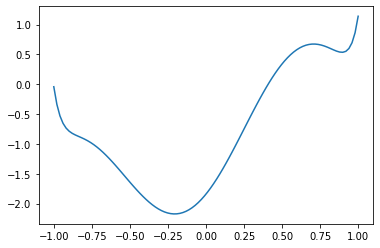

In [12]:
x = np.linspace(-1,1,100)
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
plt.plot(x, f(x))

In [13]:
def samesign(a, b):
        return a*b > 0
def bisect(func, low, high):
    assert not samesign(func(low), func(high))
    n = 20
    e = 0.01 # the epsilon or error we justify for tolerance
    for i in range(n):
        if abs(func(low)-func(high)) > e:
            midpoint = (low + high) / 2
            print(i, midpoint, f(midpoint))
            if samesign(func(low), func(midpoint)):
                low = midpoint
            else:
                high = midpoint
        else:
            #return round(midpoint, 2)
            return midpoint
    return midpoint
bisect(f, -1, 1)

0 0.0 -1.8414709848078965
1 0.5 0.3414719384822129
2 0.25 -0.7499999999990905
3 0.375 -0.14557445837149363
4 0.4375 0.11913882602594983
5 0.40625 -0.008652712067264812
6 0.421875 0.05648211190683239
7 0.4140625 0.024212599019902914
8 0.41015625 0.00785290269330119
9 0.408203125 -0.0003818562970667738


0.408203125

# 1.2 (stretch) Recursive Bisect

Write a recursive version of the bisection algorithm

# 2.1 Movies Regression

Write the best linear regression model you can on the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings.csv) to predict the profitability of a movie (revenue - budget). Maintain the interpretability of the model.

Few notes:

1. Clean your data! Movies where the budget or revenue are invalid should be thrown out

2. Be creative with feature engineering. You can include processing to one-hot encode the type of movie, etc.

3. The model should be useful for someone **who is thinking about making a movie**. So features like the popularity can't be used. You could, however, use the ratings to figure out if making "good" or "oscar bait" movies is a profitable strategy.

In [54]:
df = pd.read_csv('data/movies_metadata.csv')
df.columns

#cleaning data



#remove na value 
df = df.dropna(subset = ["budget", "revenue", "runtime"])


df['release_date'] = pd.to_datetime(df['release_date'], format = '%Y-%m-%d', errors='coerce')
df.budget = df.budget.astype(int)
df.revenue = df.revenue.astype(int)

#remove unreleased movie 
df = df[df.status == 'Released']

#remove movie with budget and revenue = 0
df = df[df.budget != 0]
df = df[df.revenue != 0]

df = df.drop(columns = ["id", "imdb_id", "overview", "poster_path", "popularity", 
                        "vote_average", "vote_count", "tagline", "title", "original_title"])


#df.info()

#convert to dummy variable 

df['adult'] = pd.get_dummies(df['adult'])
#df['belongs_to_collection'].isna().count()

quant = ['belongs_to_collection', 'homepage', 'video']

poly = ['budget']

qual = ['director','original_language']

for col in quant:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    df[col+'_missing'] = (df[col] == 0).astype(int)

df

,adult,belongs_to_collection,budget,genres,homepage,original_language,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,video,belongs_to_collection_missing,homepage_missing,video_missing
0,1,0.0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0.0,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,False,1,1,1
1,1,0.0,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0.0,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,False,1,1,1
3,1,0.0,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0.0,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,False,1,1,1
5,1,0.0,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",0.0,en,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,False,1,1,1
8,1,0.0,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",0.0,en,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,False,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,1,0.0,12000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",0.0,ta,"[{'name': 'AVM Productions', 'id': 16424}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",2007-06-14,19000000,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,False,1,1,1
45399,1,0.0,750000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",0.0,ru,"[{'name': 'Кинокомпания «Lunapark»', 'id': 420...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2014-06-05,3,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,False,1,1,1
45409,1,0.0,800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0.0,en,[],[],2006-11-23,1328612,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,False,1,1,1
45412,1,0.0,2000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",0.0,en,"[{'name': 'Profit', 'id': 21163}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2010-09-30,1268793,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,False,1,1,1


In [94]:
df.genres

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
5        [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
8        [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
                               ...                        
45250    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
45399    [{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...
45409    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
45412    [{'id': 10749, 'name': 'Romance'}, {'id': 18, ...
45422    [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...
Name: genres, Length: 5376, dtype: object

In [55]:
def x_1(x):
    try:
        return eval(x)
    except Exception as e :
        print(x)
        raise e

json_features = ['genres', 'production_countries', 'spoken_languages'] #'production_companies',

for f in json_features:
    x = (df[f]
            .fillna('')
            .apply(x_1)
            .apply(lambda row : [d['name'] for d in row])
            .astype(str)
            .str.replace("[", "")
            .str.replace("]", "")
            .str.replace("'", "")
            .str.strip()
            .str.replace(" ", "")
            .str.get_dummies(',')
            )
    x.columns = [f + "_" + s for s in x.columns]
    df = df.join(x)
df 
#df = df.join(GROSSE_FONCTION)

,adult,belongs_to_collection,budget,genres,homepage,original_language,production_companies,production_countries,release_date,revenue,...,spoken_languages_বাংলা,spoken_languages_ਪੰਜਾਬੀ,spoken_languages_தமிழ்,spoken_languages_తెలుగు,spoken_languages_ภาษาไทย,spoken_languages_ქართული,spoken_languages_广州话/廣州話,spoken_languages_日本語,spoken_languages_普通话,spoken_languages_한국어/조선말
0,1,0.0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0.0,en,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0.0,en,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249,...,0,0,0,0,0,0,0,0,0,0
3,1,0.0,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0.0,en,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156,...,0,0,0,0,0,0,0,0,0,0
5,1,0.0,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",0.0,en,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,187436818,...,0,0,0,0,0,0,0,0,0,0
8,1,0.0,35000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",0.0,en,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,64350171,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,1,0.0,12000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",0.0,ta,"[{'name': 'AVM Productions', 'id': 16424}]","[{'iso_3166_1': 'IN', 'name': 'India'}]",2007-06-14,19000000,...,0,0,1,1,0,0,0,0,0,0
45399,1,0.0,750000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",0.0,ru,"[{'name': 'Кинокомпания «Lunapark»', 'id': 420...","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2014-06-05,3,...,0,0,0,0,0,0,0,0,0,0
45409,1,0.0,800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0.0,en,[],[],2006-11-23,1328612,...,0,0,0,0,0,0,0,0,0,0
45412,1,0.0,2000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",0.0,en,"[{'name': 'Profit', 'id': 21163}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",2010-09-30,1268793,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df = df.drop(columns=['adult', 'video', 'genres', 'production_companies', 'production_countries', 'spoken_languages'])
df = df.drop(columns=['original_language'])
df = df.drop(columns=['release_date'])
df = df.drop(columns=['status'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5376 entries, 0 to 45422
Columns: 5597 entries, belongs_to_collection to spoken_languages_한국어/조선말
dtypes: float64(3), int32(5), int64(5588), object(1)
memory usage: 229.7+ MB


In [65]:
# regression model based on vote_count

x = df['budget']
X = sm.add_constant(x)
y = df['revenue']
#est = sm.OLS(y, sm.add_constant(X.astype(float))).fit(cov_type='HC2')
est = sm.OLS(y.astype(float), X.astype(float)).fit(cov_type='HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     640.7
Date:                Wed, 03 Feb 2021   Prob (F-statistic):          1.23e-133
Time:                        20:49:39   Log-Likelihood:            -1.0748e+05
No. Observations:                5376   AIC:                         2.150e+05
Df Residuals:                    5374   BIC:                         2.150e+05
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.857e+05   2.65e+06     -0.335      0.738   -6.07e+06     4.3e+06
budget         2.9038      0.115     25.312      0.000       2.679       3.129
==============================================================================
Omnibus:                     2043.822   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1518544.031
Skew:                          -0.093   Prob(JB):                         0.00
Kurtosis:                      85.336   Cond. No.                     6.43e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 6.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2.2 Movies Manual Regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using the normal equation $(X^T X)^{-1}X^Ty$.

Verify that the coefficients are the same.

In [66]:
# linear least squares
from numpy.linalg import inv
b = inv(X.T.dot(X)).dot(X.T).dot(y)
print(b)

[-8.85710046e+05  2.90375745e+00]


# 2.3 Movies gradient descent regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using **gradient descent**. 

Hint: use `scipy.optimize` and remember we're finding the $\beta$ that minimizes the squared loss function of linear regression: $f(\beta) = (\beta X - y)^2$. This will look like part 3 of this lecture.

Verify your coefficients are similar to the ones in 2.1 and 2.2. They won't necessarily be exactly the same, but should be roughly similar.

In [67]:
def Gradient(betas, y, x):
    res = np.sum( (np.dot(X, betas) - y) ** 2 )
    return res

In [68]:
from scipy.optimize import minimize

#create beta hat vector to maximize on
#will store the values of maximum likelihood beta parameters
#Arbitrarily initialized to all zeros
bhat = np.zeros(np.shape(X)[1])

#unvectorized MLE estimation
probit_est = minimize(Gradient, bhat, args=(y,x), method='nelder-mead')

#print vector of maximized betahats
probit_est['x']

array([-8.85709795e+05,  2.90375744e+00])